In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For potentially saving/loading models/preprocessors

# --- Sklearn ---
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler # Added StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# --- Model Libraries ---
import catboost
from catboost import CatBoostClassifier
import xgboost as xgb
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, logging as hf_logging

In [2]:
# --- Configuration ---
# Paths
data_path_cleaned = r'D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\cleaned_taptap_reviews.csv' # For CatBoost, XGBoost
data_path_lm = r'D:\GitHubRepos\is6941-ml-social-media\taptap\data\integrated\lm_cleaned_taptap_reviews.csv' # For BERT
output_dir = 'stacking_outputs_comp_key' # Changed output dir name
os.makedirs(output_dir, exist_ok=True)

# Split & CV Params
test_size = 0.2
n_splits = 5 # Number of folds for K-Fold CV
random_state = 42

# Target Column
target_column = 'sentiment'

# --- !!! Define Composite Key Columns !!! ---
composite_key_cols = ['user_id', 'publish_time', 'game_name']

# Base Model Params (Keep consistent with your original scripts)
# CatBoost
cb_params = {
    'iterations': 1000, 'learning_rate': 0.1, 'depth': 8,
    'loss_function': 'Logloss', 'eval_metric': 'Accuracy',
    'task_type': "GPU", 'devices': '0', 'random_seed': random_state,
    'verbose': 0, # Quieter for stacking loops
    'early_stopping_rounds': 50,
    'text_features': ['review_content_cleaned'], # Will use renamed column
    'cat_features': ['game_name'] # game_name is also part of the key
}
# XGBoost (Define preprocessing separately)
xgb_params = {
    'objective': 'binary:logistic', 'eval_metric': 'logloss',
    'use_label_encoder': False, 'n_estimators': 1200,
    'learning_rate': 0.05, 'max_depth': 10, 'subsample': 0.8,
    'colsample_bytree': 0.8, 'random_state': random_state,
    'early_stopping_rounds': 50, 'tree_method': 'hist', 'device': 'cuda'
}
# BERT
bert_model_name = "bert-base-chinese"
bert_train_args = TrainingArguments(
    output_dir=os.path.join(output_dir, 'bert_temp'),
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3, # Keep epochs reasonable for multiple runs
    eval_strategy="no", # No eval during OOF training
    save_strategy="no",
    logging_steps=500, # Log less often
    fp16=True,
    dataloader_pin_memory=True,
    report_to="none", # Disable wandb/tensorboard logging during OOF
    # learning_rate=3e-5, warmup_ratio=0.1, weight_decay=0.01,
)

# Disable excessive logging from transformers
hf_logging.set_verbosity_error()

# --- GPU Check ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device == torch.device("cpu"):
    print("警告: 未检测到兼容 CUDA 的 GPU。BERT 训练和预测会非常慢。")
    # Adjust params if no GPU
    cb_params['task_type'] = 'CPU'
    if 'devices' in cb_params: del cb_params['devices']
    xgb_params['device'] = 'cpu'
    bert_train_args.fp16 = False

Using device: cuda


In [ ]:
# --- 1. Load Data ---
print("加载数据...")
try:
    # Load raw data, ensuring key columns are read
    df_cleaned_raw = pd.read_csv(data_path_cleaned)
    df_lm_raw = pd.read_csv(data_path_lm)
    print(f"原始 df_cleaned: {len(df_cleaned_raw)} 行, df_lm: {len(df_lm_raw)} 行")

    # --- Define columns needed ---
    # Features specific to CB/XGB (excluding keys already listed)
    cb_xgb_only_feature_cols = ['review_content', 'likes']
    # Features specific to BERT (excluding keys)
    bert_only_feature_cols = ['review_content']
    # Target
    target_col_list = [target_column]

    # --- !!! Create UNIQUE lists of needed columns !!! ---
    needed_cols_cleaned = list(set(composite_key_cols + cb_xgb_only_feature_cols + target_col_list + ['game_name'])) # Ensure game_name is included once
    needed_cols_lm = list(set(composite_key_cols + bert_only_feature_cols + target_col_list))

    # Select needed columns early
    df_cleaned_raw = df_cleaned_raw[needed_cols_cleaned]
    df_lm_raw = df_lm_raw[needed_cols_lm]

    # --- Ensure Key Column Types are Consistent ---
    try:
        df_cleaned_raw['publish_time'] = pd.to_datetime(df_cleaned_raw['publish_time'])
        df_lm_raw['publish_time'] = pd.to_datetime(df_lm_raw['publish_time'])
    except Exception as e:
        print(f"警告：转换 'publish_time' 为 datetime 时出错: {e}. 可能影响合并。")
    for col in ['user_id', 'game_name']:
        if col in df_cleaned_raw.columns:
            df_cleaned_raw[col] = df_cleaned_raw[col].astype(str)
        if col in df_lm_raw.columns:
            df_lm_raw[col] = df_lm_raw[col].astype(str)

    # --- Clean df_cleaned ---
    print("清理 df_cleaned...")
    df_cleaned_processed = df_cleaned_raw.copy()
    df_cleaned_processed['review_content'] = df_cleaned_processed['review_content'].fillna('')
    if 'game_name' in df_cleaned_processed.columns:
        df_cleaned_processed['game_name'] = df_cleaned_processed['game_name'].fillna('Unknown')
    df_cleaned_processed.dropna(subset=['likes', target_column], inplace=True)
    df_cleaned_processed[target_column] = df_cleaned_processed[target_column].astype(int)
    df_cleaned_processed = df_cleaned_processed.drop_duplicates(subset=composite_key_cols, keep='first')
    print(f"清理后 df_cleaned: {len(df_cleaned_processed)} 行")

    # --- Clean df_lm ---
    print("清理 df_lm...")
    df_lm_processed = df_lm_raw.copy()
    df_lm_processed.dropna(subset=['review_content', target_column], inplace=True)
    df_lm_processed[target_column] = df_lm_processed[target_column].astype(int)
    df_lm_processed = df_lm_processed.drop_duplicates(subset=composite_key_cols, keep='first')
    print(f"清理后 df_lm: {len(df_lm_processed)} 行")

    # --- Merge to Align based on Composite Key ---
    print("使用复合键合并以对齐数据...")

    # --- !!! Define UNIQUE columns for merging !!! ---
    # Columns needed from cleaned df (keys + specific features + target)
    cols_to_merge_cleaned = list(set(composite_key_cols + cb_xgb_only_feature_cols + target_col_list + ['game_name']))
    # Columns needed from lm df (keys + specific features)
    cols_to_merge_lm = list(set(composite_key_cols + bert_only_feature_cols))

    # Select necessary columns and rename review_content for clarity before merge
    df_cleaned_to_merge = df_cleaned_processed[cols_to_merge_cleaned].rename(
        columns={'review_content': 'review_content_cleaned'}
    )
    df_lm_to_merge = df_lm_processed[cols_to_merge_lm].rename(
        columns={'review_content': 'review_content_lm'}
    )

    # Inner merge
    df_aligned = pd.merge(df_cleaned_to_merge, df_lm_to_merge, on=composite_key_cols, how='inner')

    if len(df_aligned) == 0:
        print("错误：数据对齐后没有剩余样本。请检查清理逻辑、复合键的唯一性和数据对应关系。")
        exit()

    # --- Create a Simple Unique ID for easier indexing ---
    df_aligned = df_aligned.reset_index(drop=True)
    df_aligned['review_id'] = df_aligned.index
    df_aligned = df_aligned.set_index('review_id', drop=False)

    print(f"数据对齐完成。最终用于训练/测试的样本数: {len(df_aligned)}")

    # --- Extract Final Features and Target ---
    y = df_aligned[target_column]
    X_for_split = df_aligned[['review_id']]
    n_classes = y.nunique()

except FileNotFoundError as e:
    print(f"错误: 文件未找到 - {e}")
    exit()
except KeyError as e:
    print(f"错误: 缺少必要的列 - {e}. 请确保CSV文件包含 {composite_key_cols} 以及特征和目标列。")
    exit()
except Exception as e:
    print(f"加载或预处理数据时发生错误: {e}")
    exit()

加载数据...
原始 df_cleaned: 39985 行, df_lm: 39985 行
清理 df_cleaned...
清理后 df_cleaned: 39985 行
清理 df_lm...
清理后 df_lm: 39985 行
使用复合键合并以对齐数据...
数据对齐完成。最终用于训练/测试的样本数: 39985


In [4]:
# --- 2. Initial Train/Test Split ---
# Split the ALIGNED review_ids
train_ids, test_ids, y_train_orig, y_test_final = train_test_split(
    df_aligned['review_id'].values, # Split the simple IDs
    y.values,                      # Split the corresponding labels
    test_size=test_size,
    random_state=random_state,
    stratify=y
)

print(f"初始划分: 训练集 {len(train_ids)} 样本 (IDs), 测试集 {len(test_ids)} 样本 (IDs)")

初始划分: 训练集 31988 样本 (IDs), 测试集 7997 样本 (IDs)


In [5]:
# --- 3. Define Base Model Training/Prediction Functions ---

# == XGBoost Preprocessor ==
xgb_text_col = 'review_content_cleaned' # Use the renamed column
xgb_cat_cols = ['game_name']
xgb_num_cols = ['likes']

xgb_text_transformer = Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=5000, stop_words=None))])
xgb_cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
xgb_num_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('text', xgb_text_transformer, xgb_text_col),
        ('cat', xgb_cat_transformer, xgb_cat_cols),
        ('num', xgb_num_transformer, xgb_num_cols)
    ],
    remainder='passthrough'
)

# == BERT Dataset ==
class SentimentDataset(Dataset):
    # (Dataset class remains the same)
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            return_token_type_ids=False, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize BERT tokenizer globally
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)

In [6]:
# --- 4. Generate OOF and Test Predictions ---
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Initialize arrays to store predictions (using length of train_ids)
oof_preds_catboost = np.zeros((len(train_ids), n_classes))
oof_preds_xgb = np.zeros((len(train_ids), n_classes))
oof_preds_bert = np.zeros((len(train_ids), n_classes))

# Use length of test_ids for test predictions
test_preds_catboost = np.zeros((len(test_ids), n_classes))
test_preds_xgb = np.zeros((len(test_ids), n_classes))
test_preds_bert = np.zeros((len(test_ids), n_classes))

# Store fitted base models for test prediction later
base_models_catboost = []
base_models_xgb_pipe = [] # Store the whole pipeline for XGB
base_models_bert = []

print(f"\n开始 {n_splits}-折交叉验证生成 OOF 预测...")

# kf.split now operates on a placeholder array of the size of train_ids
# train_fold_idx/val_fold_idx are indices *within* train_ids array
for fold, (train_fold_local_idx, val_fold_local_idx) in enumerate(kf.split(np.zeros(len(train_ids)), y_train_orig)):
    print(f"--- Fold {fold+1}/{n_splits} ---")
    fold_start_time = time.time()

    # --- Get actual review_ids for this fold ---
    train_fold_ids = train_ids[train_fold_local_idx]
    val_fold_ids = train_ids[val_fold_local_idx]

    # --- Get data for this fold using review_ids from df_aligned ---
    # Use .loc with the simple review_id index
    X_train_fold_aligned = df_aligned.loc[train_fold_ids]
    y_train_fold = y.loc[train_fold_ids]
    X_val_fold_aligned = df_aligned.loc[val_fold_ids]
    y_val_fold = y.loc[val_fold_ids]

    # --- Train CatBoost ---
    print(f"  训练 CatBoost...")
    cb_model = CatBoostClassifier(**cb_params)
    # Features for CatBoost from X_train_fold_aligned
    cb_features_train = X_train_fold_aligned[['review_content_cleaned', 'game_name', 'likes']]
    cb_features_val = X_val_fold_aligned[['review_content_cleaned', 'game_name', 'likes']]

    cb_model.fit(cb_features_train, y_train_fold,
                 eval_set=(cb_features_val, y_val_fold)
                 # text_features and cat_features are defined in cb_params
                )
    # Store predictions in OOF array using val_fold_local_idx
    oof_preds_catboost[val_fold_local_idx] = cb_model.predict_proba(cb_features_val)
    base_models_catboost.append(cb_model)
    print(f"  CatBoost 训练完成。")

    # --- Train XGBoost ---
    print(f"  训练 XGBoost...")
    xgb_pipe_fold = Pipeline(steps=[('preprocessor', xgb_preprocessor),
                                    ('classifier', xgb.XGBClassifier(**xgb_params))])
    # Define columns for XGBoost pipeline input
    xgb_input_cols = [xgb_text_col] + xgb_cat_cols + xgb_num_cols
    # Fit preprocessor on fold training data
    xgb_preprocessor_fitted = xgb_pipe_fold.named_steps['preprocessor'].fit(X_train_fold_aligned[xgb_input_cols])
    # Transform data
    X_train_processed = xgb_preprocessor_fitted.transform(X_train_fold_aligned[xgb_input_cols])
    X_val_processed = xgb_preprocessor_fitted.transform(X_val_fold_aligned[xgb_input_cols])
    # Fit classifier with early stopping
    xgb_pipe_fold.named_steps['classifier'].fit(X_train_processed, y_train_fold,
                                                eval_set=[(X_val_processed, y_val_fold)],
                                                verbose=False)
    # Predict probabilities using the fitted pipeline
    oof_preds_xgb[val_fold_local_idx] = xgb_pipe_fold.predict_proba(X_val_fold_aligned[xgb_input_cols])
    base_models_xgb_pipe.append(xgb_pipe_fold)
    print(f"  XGBoost 训练完成。")

    # --- Train BERT ---
    print(f"  训练 BERT...")
    bert_model = BertForSequenceClassification.from_pretrained(bert_model_name, num_labels=n_classes)
    bert_model.to(device)
    # Get LM text data for the fold
    X_train_fold_lm_texts = X_train_fold_aligned['review_content_lm'].tolist()
    X_val_fold_lm_texts = X_val_fold_aligned['review_content_lm'].tolist()

    train_fold_dataset = SentimentDataset(X_train_fold_lm_texts, y_train_fold.tolist(), bert_tokenizer)
    trainer = Trainer(model=bert_model, args=bert_train_args, train_dataset=train_fold_dataset)
    trainer.train()

    # Predict on validation fold
    val_fold_dataset = SentimentDataset(X_val_fold_lm_texts, y_val_fold.tolist(), bert_tokenizer)
    val_predictions = trainer.predict(val_fold_dataset)
    oof_preds_bert[val_fold_local_idx] = torch.softmax(torch.tensor(val_predictions.predictions), dim=-1).numpy()
    base_models_bert.append(bert_model)
    print(f"  BERT 训练完成。")

    fold_end_time = time.time()
    print(f"--- Fold {fold+1} 完成, 耗时: {fold_end_time - fold_start_time:.2f} 秒 ---")

print(f"\nOOF 预测生成完毕。")

# --- Generate Test Predictions using models trained on full training data ---
print("\n使用 K-Fold 模型平均生成测试集预测...")
# Get test data using test_ids from df_aligned
X_test_aligned = df_aligned.loc[test_ids]
y_test_final = y.loc[test_ids] # Ensure y_test_final is correct

# Average CatBoost predictions
cb_features_test = X_test_aligned[['review_content_cleaned', 'game_name', 'likes']]
test_preds_catboost_all_folds = np.array([model.predict_proba(cb_features_test) for model in base_models_catboost])
test_preds_catboost = np.mean(test_preds_catboost_all_folds, axis=0)

# Average XGBoost predictions
xgb_input_cols = [xgb_text_col] + xgb_cat_cols + xgb_num_cols
test_preds_xgb_all_folds = np.array([pipe.predict_proba(X_test_aligned[xgb_input_cols]) for pipe in base_models_xgb_pipe])
test_preds_xgb = np.mean(test_preds_xgb_all_folds, axis=0)

# Average BERT predictions
X_test_lm_texts = X_test_aligned['review_content_lm'].tolist()
test_dataset_final = SentimentDataset(X_test_lm_texts, y_test_final.tolist(), bert_tokenizer)
test_preds_bert_all_folds = []
dummy_args = TrainingArguments(output_dir=os.path.join(output_dir, 'bert_dummy'), report_to="none", per_device_eval_batch_size=64, fp16=bert_train_args.fp16)
for model in base_models_bert:
    model.eval()
    dummy_trainer = Trainer(model=model, args=dummy_args)
    with torch.no_grad():
        predictions = dummy_trainer.predict(test_dataset_final)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=-1).cpu().numpy()
    test_preds_bert_all_folds.append(probs)
test_preds_bert = np.mean(np.array(test_preds_bert_all_folds), axis=0)

print("测试集预测生成完毕。")


开始 5-折交叉验证生成 OOF 预测...
--- Fold 1/5 ---
  训练 CatBoost...
  CatBoost 训练完成。
  训练 XGBoost...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:24:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()
c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\core.py:729: UserWarning: [21:24:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


  XGBoost 训练完成。
  训练 BERT...


Step,Training Loss
500,0.447300
1000,0.371600
1500,0.314000
2000,0.234300


  BERT 训练完成。
--- Fold 1 完成, 耗时: 435.70 秒 ---
--- Fold 2/5 ---
  训练 CatBoost...


  CatBoost 训练完成。
  训练 XGBoost...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:31:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


  XGBoost 训练完成。
  训练 BERT...


Step,Training Loss
500,0.456900
1000,0.361800
1500,0.303600
2000,0.208600


  BERT 训练完成。
--- Fold 2 完成, 耗时: 434.44 秒 ---
--- Fold 3/5 ---
  训练 CatBoost...


  CatBoost 训练完成。
  训练 XGBoost...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:38:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


  XGBoost 训练完成。
  训练 BERT...


Step,Training Loss
500,0.449800
1000,0.365000
1500,0.305200
2000,0.232900


  BERT 训练完成。
--- Fold 3 完成, 耗时: 425.86 秒 ---
--- Fold 4/5 ---
  训练 CatBoost...


  CatBoost 训练完成。
  训练 XGBoost...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:45:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


  XGBoost 训练完成。
  训练 BERT...


Step,Training Loss
500,0.440400
1000,0.365700
1500,0.290300
2000,0.196200


  BERT 训练完成。
--- Fold 4 完成, 耗时: 421.46 秒 ---
--- Fold 5/5 ---
  训练 CatBoost...


  CatBoost 训练完成。
  训练 XGBoost...


c:\Users\wjw20\miniconda3\envs\IS6941\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:52:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


  XGBoost 训练完成。
  训练 BERT...


Step,Training Loss
500,0.440900
1000,0.357100
1500,0.294000
2000,0.201000


  BERT 训练完成。
--- Fold 5 完成, 耗时: 409.02 秒 ---

OOF 预测生成完毕。

使用 K-Fold 模型平均生成测试集预测...
测试集预测生成完毕。


In [7]:
# --- 5. Prepare Meta-Model Input ---
print("\n准备 Meta-Model 输入...")
# X_meta_train uses the OOF predictions
X_meta_train = np.concatenate([oof_preds_catboost, oof_preds_xgb, oof_preds_bert], axis=1)
# X_meta_test uses the averaged test predictions
X_meta_test = np.concatenate([test_preds_catboost, test_preds_xgb, test_preds_bert], axis=1)

print(f"Meta Train 特征维度: {X_meta_train.shape}") # Should be (n_train_samples, n_models * n_classes)
print(f"Meta Test 特征维度: {X_meta_test.shape}")   # Should be (n_test_samples, n_models * n_classes)


准备 Meta-Model 输入...
Meta Train 特征维度: (31988, 6)
Meta Test 特征维度: (7997, 6)


In [27]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform # For defining parameter distributions

# --- 替换步骤 6 ---
print("\n训练 Meta-Model (Logistic Regression with GridSearchCV for C)...")
# 定义参数网格
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
# 使用 StratifiedKFold 进行内部交叉验证以选择 C
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
# 初始化 Logistic Regression
lr_meta = LogisticRegression(random_state=random_state, max_iter=2000, solver='liblinear') # solver='liblinear' 对 L1/L2 都适用

# 设置 GridSearchCV
meta_model_search = GridSearchCV(estimator=lr_meta,
                                 param_grid=param_grid,
                                 cv=inner_cv,
                                 scoring='accuracy', # 或 'f1_weighted' 等
                                 refit=True, # 用最佳参数在整个 X_meta_train 上重新训练
                                 verbose=1) # 显示搜索过程

# 在 OOF 预测和原始训练标签上进行搜索和训练
meta_model_search.fit(X_meta_train, y_train_orig)

print(f"Meta-Model 最佳参数 (C): {meta_model_search.best_params_}")
print(f"Meta-Model 最佳 CV 分数: {meta_model_search.best_score_:.4f}")
# 最优模型存储在 meta_model_search.best_estimator_
meta_model = meta_model_search.best_estimator_ # 使用找到的最佳模型
print("Meta-Model 训练完成。")

# # --- 替换步骤 6 ---
# print("\n训练 Meta-Model (LightGBM with RandomizedSearch)...")

# # --- 定义 LightGBM Meta-Model 的参数搜索空间 ---
# # 可以根据需要调整范围和分布类型
# param_dist = {
#     'n_estimators': randint(50, 500), # 随机整数范围
#     'learning_rate': uniform(0.01, 0.2), # 均匀分布
#     'num_leaves': randint(10, 50),
#     'max_depth': randint(3, 10),
#     'reg_alpha': uniform(0, 1), # L1 正则化
#     'reg_lambda': uniform(0, 1), # L2 正则化
#     # 'colsample_bytree': uniform(0.6, 0.4), # 0.6 to 1.0 (0.6 + 0.4)
#     # 'subsample': uniform(0.6, 0.4)
# }

# # 初始化基础 LightGBM 分类器
# lgbm_meta_base = lgb.LGBMClassifier(
#     objective='binary',
#     metric='binary_logloss',
#     seed=random_state,
#     n_jobs=-1,
#     verbose=-1 # 关闭 LightGBM 自身的啰嗦输出
# )

# # 设置内部交叉验证策略 (用于评估超参数)
# # 使用与外部 K-Fold 不同的 random_state 是个好习惯，但也可以相同
# inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state + 1)

# # 设置 RandomizedSearchCV
# # n_iter 控制抽样的参数组合数量
# n_iter_search = 50 # 可以增加这个值以进行更广泛的搜索，但会增加时间
# meta_model_search = RandomizedSearchCV(
#     estimator=lgbm_meta_base,
#     param_distributions=param_dist,
#     n_iter=n_iter_search, # 尝试的参数组合数量
#     cv=inner_cv,
#     scoring='accuracy', # 或 'f1_weighted', 'roc_auc' 等
#     refit=True, # 用找到的最佳参数在整个 X_meta_train 上重新训练模型
#     random_state=random_state, # 控制抽样的随机性
#     verbose=1 # 显示搜索进度
# )

# print(f"开始在 {n_iter_search} 个参数组合上进行 RandomizedSearch...")
# # 在 OOF 预测 (X_meta_train) 和原始训练标签 (y_train_orig) 上进行搜索和训练
# start_search_time = time.time()
# meta_model_search.fit(X_meta_train, y_train_orig)
# end_search_time = time.time()
# print(f"RandomizedSearch 完成，耗时: {end_search_time - start_search_time:.2f} 秒")

# print(f"\nMeta-Model (LightGBM) 最佳参数: {meta_model_search.best_params_}")
# print(f"Meta-Model (LightGBM) 最佳 CV 分数: {meta_model_search.best_score_:.4f}")

# # 最优模型存储在 meta_model_search.best_estimator_
# meta_model = meta_model_search.best_estimator_
# print("Meta-Model (LightGBM with best params) 训练完成。")


训练 Meta-Model (Logistic Regression with GridSearchCV for C)...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Meta-Model 最佳参数 (C): {'C': 10}
Meta-Model 最佳 CV 分数: 0.8608
Meta-Model 训练完成。


In [28]:
# --- 7. Final Prediction with Meta-Model ---
print("\n使用 Meta-Model 在测试集上进行最终预测...")
final_predictions = meta_model.predict(X_meta_test)
final_probabilities = meta_model.predict_proba(X_meta_test)


使用 Meta-Model 在测试集上进行最终预测...



--- Stacking 集成模型最终评估 ---
分类报告:
              precision    recall  f1-score   support

           0       0.83      0.72      0.77      2726
           1       0.86      0.92      0.89      5271

    accuracy                           0.85      7997
   macro avg       0.85      0.82      0.83      7997
weighted avg       0.85      0.85      0.85      7997


最终准确率: 0.8531

混淆矩阵:
[[1960  766]
 [ 409 4862]]


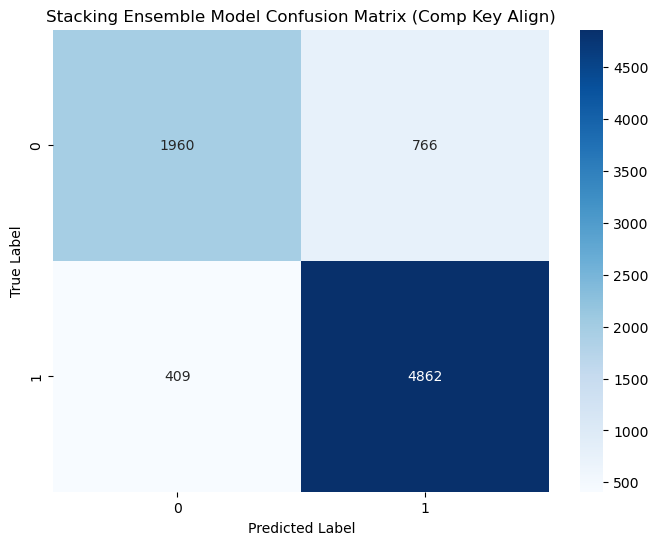


Stacking 脚本执行完毕。


In [29]:
# --- 8. Evaluate Final Stacked Model ---
print("\n--- Stacking 集成模型最终评估 ---")

# Classification Report
print("分类报告:")
try:
    # Ensure y_test_final is used here
    target_names = [str(c) for c in sorted(np.unique(y_test_final))] # Use unique values from y_test_final
    print(classification_report(y_test_final, final_predictions, target_names=target_names))
except Exception as e:
    print(f"生成分类报告时出错: {e}")
    print(classification_report(y_test_final, final_predictions))

# Accuracy
accuracy = accuracy_score(y_test_final, final_predictions)
print(f"\n最终准确率: {accuracy:.4f}")

# Confusion Matrix
print("\n混淆矩阵:")
cm = confusion_matrix(y_test_final, final_predictions)
print(cm)

# Visualize Confusion Matrix
try:
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Stacking Ensemble Model Confusion Matrix (Comp Key Align)') # Updated title
    plt.show()
except NameError:
    print("\n无法绘制混淆矩阵，可能缺少 target_names。")
except Exception as e:
    print(f"\n绘制混淆矩阵时出错: {e}")

print("\nStacking 脚本执行完毕。")

# Optional: Clean up BERT temp directories if needed
# import shutil
# shutil.rmtree(os.path.join(output_dir, 'bert_temp'), ignore_errors=True)
# shutil.rmtree(os.path.join(output_dir, 'bert_dummy'), ignore_errors=True)